Importing main libraries

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The Dataset, and some info about it

In [84]:
train = pd.read_csv('titanic_train.csv')

In [85]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# Exploring the data

## Checking missing data

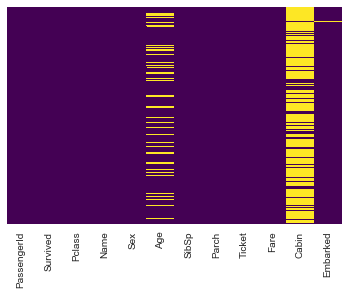

In [88]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [89]:
str((sum(train['Age'].isnull())/891)*100)[:5]

'19.86'

We have 19.86 percent of age data missing. It should be corrected somehow. The cabin column is so messy we should throw it away.

### Survivors are our desired prediction, here a main factor clearly visible


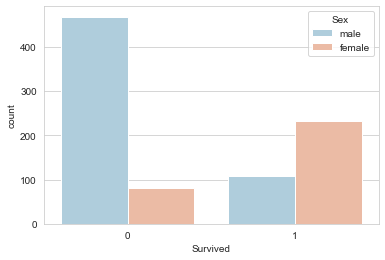

In [90]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

# Data Cleaning

We could just input the missing ages with the general average of the sample.
However, we could easily do better than it.
One possibility is taking the mean age by the Pclass feature.


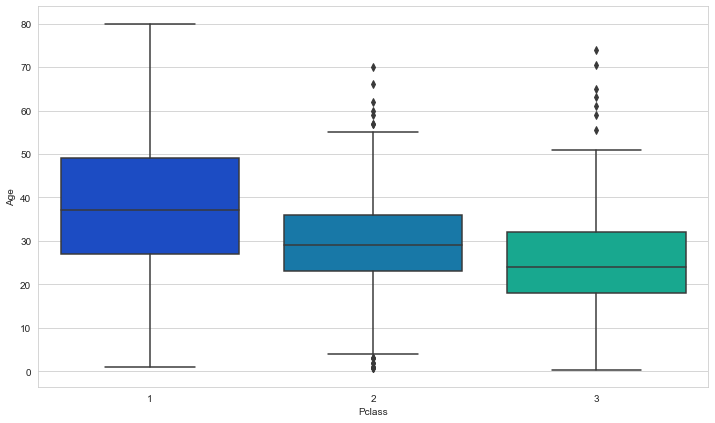

In [91]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Now we should apply a function to the column age - which is a pandas.series object - to correct them all based on the above average by Pclass.

Here a general example from the documentation on how to apply those functions

In [92]:
s = pd.Series([20, 21, 12],
...               index=['London', 'New York', 'Helsinki'])
def square(x):
...     return x ** 2
s.apply(square)

London      400
New York    441
Helsinki    144
dtype: int64

Now our input_age function:

In [93]:
def imput_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age


In [94]:
train['Age'] = train[['Age','Pclass']].apply(imput_age,axis=1)

Now we check the heat map again. There should be no missing age.

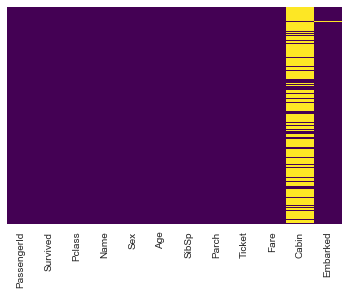

In [95]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

To finish the data cleaning we should drop the Cabin column and the NaN embarked row

In [96]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas. Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [98]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [99]:
train.drop(['Sex','Embarked','Ticket'],axis=1,inplace=True)

In [100]:
train = pd.concat([train,sex,embark],axis=1)

In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
male           889 non-null uint8
Q              889 non-null uint8
S              889 non-null uint8
dtypes: float64(2), int64(5), object(1), uint8(3)
memory usage: 65.1+ KB


We still have one non-numerical feature, the name. We could just drop it, but maybe we'll find useful data on the titles (Mr., Miss. etc). 
I will create a new column on train, named Title, based on the Name column. To separate the title from the name I created a function split_1 which is applied below.

But before I will separate it in a new DataFrame to check if the new feature came with any improvement in prediction.


In [102]:
train_without_title = train.copy()
train_without_title.drop(['Name'],axis=1,inplace=True)


In [103]:
def split_1(string):
    # I'm double splitting because of some two-word last names, so I need to find the title after the comma, not at [1]
    # I'm returnin np.nan on uncommon or wrong titles because that error creates me 40 extra columns hehehe
    if 'M' not in str(string).split(',')[1].split()[0]:
        return np.nan
    else:
        return str(string).split(',')[1].split()[0]

In [104]:
train['Title']=train['Name'].apply(split_1)

In [105]:
train['Title'][0:11]

0         Mr.
1        Mrs.
2       Miss.
3        Mrs.
4         Mr.
5         Mr.
6         Mr.
7     Master.
8        Mrs.
9        Mrs.
10      Miss.
Name: Title, dtype: object

Ok, the title was sucessfully separated. Now we should dummy it to transform the categorical data into a numerical one.

In [106]:
title = pd.get_dummies(train['Title'],drop_first=True)
train.drop(['Title','Name'],axis=1,inplace=True)
train = pd.concat([train,title],axis=1)

In [107]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 17 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
male           889 non-null uint8
Q              889 non-null uint8
S              889 non-null uint8
Master.        889 non-null uint8
Miss.          889 non-null uint8
Mlle.          889 non-null uint8
Mme.           889 non-null uint8
Mr.            889 non-null uint8
Mrs.           889 non-null uint8
Ms.            889 non-null uint8
dtypes: float64(2), int64(5), uint8(10)
memory usage: 64.2 KB


The Data is finally ready for the models.

# Machine Learning time

## Train test split

We should separate our dataset into a training and testing set, using sklearn.

In [ ]:
from sklearn.model_selection import train_test_split

The predicted variable will be 'Survived' and the test set is 30% of the total data.

In [109]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

# The Random Forest Algorithm
As explained by O'Reilly Introduction to Machine Learning with Python, by Sarah Guido and Andreas Muller.

The Random Forest Classifier is an algorithm based on an ensemble of decision trees. First I'll explain what is a decision tree as it is the building block of the RandomForest.

#### Decision Tree

Is a decision support tool that uses a tree-like graph, in a flowchart structure, testing many attributes on the sample to efficiently divide the data and label a combination of features.
Essentially, they learn a hierarchy of if/else questions, leading to a decision.
It is a simple way to make a prediction, accepts both categorical and continuous data and requires little data preparation. Still, it may be inefficient once it tends to overfit with the training set, especially with deep trees, with many branches and questions. To solve this problem we have the Random Forest.

### Random Forest

A random forest
is essentially a collection of decision trees, where each tree is slightly different from
the others. The idea behind random forests is that each tree might do a relatively
good job of predicting, but will likely overfit on part of the data. If we build many
trees, all of which work well and overfit in different ways, we can reduce the amount
of overfitting by averaging their results.

To implement this strategy, we need to build many decision trees. Each tree should do
an acceptable job of predicting the target, and should also be different from the other
trees. Random forests get their name from injecting randomness into the tree building
to ensure each tree is different. There are two ways in which the trees in a random
forest are randomized: by selecting the data points used to build a tree and by selecting
the features in each split test.

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
rfc = RandomForestClassifier(n_estimators=100)

In [112]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [113]:
predictions = rfc.predict(X_test)

In [115]:
from sklearn.metrics import classification_report, confusion_matrix

In [117]:
print('Random Forest (with titles) \n',classification_report(y_test, predictions))

Random Forest (with titles) 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88       163
           1       0.85      0.74      0.79       104

    accuracy                           0.85       267
   macro avg       0.85      0.83      0.83       267
weighted avg       0.85      0.85      0.84       267



Before heading to the Naive Bayes algorithm, let's try to predict the survivors with the train_without_title dataset.

In [119]:
twt = train_without_title
X_train, X_test, y_train, y_test = train_test_split(twt.drop('Survived',axis=1), 
                                                    twt['Survived'], test_size=0.30, 
                                                    random_state=101)


rfc.fit(X_train, y_train)                                            
predictions = rfc.predict(X_test)

print('Random Forest (WITHOUT titles) \n',classification_report(y_test, predictions))
                        

Random Forest (WITHOUT titles) 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87       163
           1       0.82      0.73      0.77       104

    accuracy                           0.83       267
   macro avg       0.83      0.81      0.82       267
weighted avg       0.83      0.83      0.83       267



The answer is YES, we had a small improvement on the prediction when adding the title dummy variables.

# Naive Bayes Classifier

In [120]:
from sklearn.naive_bayes import GaussianNB

In [121]:
gnb = GaussianNB()

In [122]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

In [123]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [124]:
predictions = gnb.predict(X_test)

In [125]:
print('Naive Bayes (with titles) \n',classification_report(y_test, predictions))

Naive Bayes (with titles) 
               precision    recall  f1-score   support

           0       0.79      0.95      0.86       163
           1       0.89      0.61      0.72       104

    accuracy                           0.82       267
   macro avg       0.84      0.78      0.79       267
weighted avg       0.83      0.82      0.81       267

